Data collectioin

In [138]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("himanshikawade04/loan-eligiblity")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\AJAN\.cache\kagglehub\datasets\himanshikawade04\loan-eligiblity\versions\1


In [139]:
import shutil
import os

destination = "./data" 
os.makedirs(destination, exist_ok=True)
shutil.copytree(path, destination, dirs_exist_ok=True)

print(f"Dataset copied to: {destination}")

Dataset copied to: ./data


In [140]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

EDA

In [141]:
df = pd.read_csv(os.path.join(destination, "loan_data.csv"))

In [142]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [143]:
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


DATA PREPROCESSING AND CLEANING

In [144]:
# Remove outliers using IQR method for numerical columns
def remove_outliers_iqr(df, cols):
    df_clean = df.copy()
    for col in cols:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    return df_clean

# Remove outliers from the original dataframe (not the encoded one)
numerical_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']
df_no_outliers = remove_outliers_iqr(df, numerical_cols)

print(f"Shape before outlier removal: {df.shape}")
print(f"Shape after outlier removal: {df_no_outliers.shape}")

Shape before outlier removal: (614, 13)
Shape after outlier removal: (415, 13)


In [145]:
# Fill missing categorical values with mode and numerical values with median
for col in df.columns:
    if df[col].dtype == "object":
        df[col].fillna(df[col].mode()[0], inplace=True)
    else:
        df[col].fillna(df[col].median(), inplace=True)

df.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [146]:
# One-Hot Encoding for nominal categorical variables
nominal_cols = ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status', 'Dependents']
# Remove ordinal and target columns from nominal_cols
nominal_cols.remove('Loan_Status')  # We'll encode target separately
nominal_cols.remove('Dependents')   # 'Dependents' can be considered ordinal

df_encoded = pd.get_dummies(df, columns=nominal_cols, drop_first=True)

# Label Encoding for ordinal variables
# For 'Dependents', treat '3+' as 3
df_encoded['Dependents'] = df['Dependents'].replace('3+', 3).astype(int)

# For 'Loan_Status', encode 'Y' as 1 and 'N' as 0
df_encoded['Loan_Status'] = df['Loan_Status'].map({'Y': 1, 'N': 0})

# If you have a credit score column, encode it here (not present in this dataset)
# Example:
# df_encoded['Credit_Score'] = df['Credit_Score'].map({'Poor': 0, 'Average': 1, 'Good': 2, 'Excellent': 3})

df_encoded.head()

,Loan_ID,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Gender_Male,Married_Yes,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban
0,LP001002,0,5849,0.0,128.0,360.0,1.0,1,True,False,False,False,False,True
1,LP001003,1,4583,1508.0,128.0,360.0,1.0,0,True,True,False,False,False,False
2,LP001005,0,3000,0.0,66.0,360.0,1.0,1,True,True,False,True,False,True
3,LP001006,0,2583,2358.0,120.0,360.0,1.0,1,True,True,True,False,False,True
4,LP001008,0,6000,0.0,141.0,360.0,1.0,1,True,False,False,False,False,True


In [147]:
# Standardize ordinal columns
ordinal_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']
sc = StandardScaler()
ordinal_scaled = sc.fit_transform(df[ordinal_cols])

# Assign standardized values back to df_encoded
df_encoded[ordinal_cols] = ordinal_scaled

df_encoded.drop(columns=['Loan_ID'], inplace=True)  # Drop Loan_ID as it's not needed for modeling


In [148]:
corr_with_target = df_encoded.corr()['Loan_Status'].sort_values(ascending=False)
print(corr_with_target)

Loan_Status                1.000000
Credit_History             0.540556
Property_Area_Semiurban    0.136540
Married_Yes                0.091478
Gender_Male                0.017987
Dependents                 0.010118
Self_Employed_Yes         -0.003700
ApplicantIncome           -0.004710
Loan_Amount_Term          -0.022549
LoanAmount                -0.033214
Property_Area_Urban       -0.043621
CoapplicantIncome         -0.059187
Education_Not Graduate    -0.085884
Name: Loan_Status, dtype: float64


In [149]:
df_encoded

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Gender_Male,Married_Yes,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban
0,0,0.072991,-0.554487,-0.211241,0.273231,1.0,1,True,False,False,False,False,True
1,1,-0.134412,-0.038732,-0.211241,0.273231,1.0,0,True,True,False,False,False,False
2,0,-0.393747,-0.554487,-0.948996,0.273231,1.0,1,True,True,False,True,False,True
3,0,-0.462062,0.251980,-0.306435,0.273231,1.0,1,True,True,True,False,False,True
4,0,0.097728,-0.554487,-0.056551,0.273231,1.0,1,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,0,-0.410130,-0.554487,-0.889500,0.273231,1.0,1,False,False,False,False,False,False
610,3,-0.212557,-0.554487,-1.258378,-2.522836,1.0,1,True,True,False,False,False,False
611,1,0.437174,-0.472404,1.276168,0.273231,1.0,1,True,True,False,False,False,True
612,2,0.357064,-0.554487,0.490816,0.273231,1.0,1,True,True,False,False,False,True


MODEL TRAINING

In [150]:

# Separate features and target
X = df_encoded.drop('Loan_Status', axis=1)
y = df_encoded['Loan_Status']

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (491, 12)
Test shape: (123, 12)


In [151]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [None, 5, 10, 20],
#     'min_samples_split': [2, 5, 10],
#     'max_features': ['auto', 'sqrt', 'log2']
# }
# grid = GridSearchCV(RandomForestClassifier(random_state=1), param_grid, cv=5)
# grid.fit(X_train, y_train)
# print("Best parameters:", grid.best_params_)

In [152]:
model = RandomForestClassifier(
    max_depth=5,
    max_features='sqrt', 
    min_samples_split=2, 
    n_estimators=200,
    random_state=1
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

MODEL EVALUATION

In [153]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
confusion_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", confusion_matrix)
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.85
Confusion Matrix:
 [[21 17]
 [ 1 84]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.55      0.70        38
           1       0.83      0.99      0.90        85

    accuracy                           0.85       123
   macro avg       0.89      0.77      0.80       123
weighted avg       0.87      0.85      0.84       123



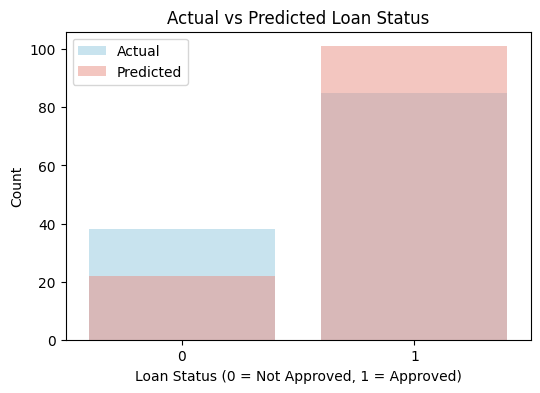

In [154]:
# Visualize the comparison between actual and predicted values
plt.figure(figsize=(6, 4))
sns.countplot(x=y_test, label='Actual', color='skyblue', alpha=0.5)
sns.countplot(x=y_pred, label='Predicted', color='salmon', alpha=0.5)
plt.title('Actual vs Predicted Loan Status')
plt.xlabel('Loan Status (0 = Not Approved, 1 = Approved)')
plt.ylabel('Count')
plt.legend(['Actual', 'Predicted'])
plt.show()